In [42]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
data_path = Path("../data")




In [43]:
# Note the Capital Letters and correct filenames
TRAIN_PATH = data_path / "Train.csv"
TEST_PATH  = data_path / "Test.csv"

train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)



In [44]:
train.head()

,ID,join_date,sex,marital_status,birth_year,branch_code,occupation_code,occupation_category_code,P5DA,RIBP,...,AHXO,BSTQ,FM3X,K6QO,QBOL,JWFN,JZ9D,J9JW,GHYX,ECY3
0,4WKQSBB,1/2/2019,F,M,1987,1X1H,2A7I,T4MS,0,0,...,0,0,0,1,0,0,0,0,0,0
1,CP5S02H,1/6/2019,F,M,1981,UAOD,2A7I,T4MS,0,0,...,0,0,0,1,0,0,0,0,0,0
2,2YKDILJ,1/6/2013,M,U,1991,748L,QZYX,90QI,0,0,...,0,0,0,0,0,0,0,0,0,1
3,2S9E81J,1/8/2019,M,M,1990,1X1H,BP09,56SI,0,0,...,0,0,0,1,0,0,0,0,0,0
4,BHDYVFT,1/8/2019,M,M,1990,748L,NO3L,T4MS,0,0,...,0,0,0,0,0,0,1,1,0,0


In [45]:
PROFILE_COLS = [
    "ID", "join_date", "sex", "marital_status", "birth_year",
    "branch_code", "occupation_code", "occupation_category_code"
]
PRODUCT_COLS = [c for c in train.columns if c not in PROFILE_COLS]

assert list(train.columns) == list(test.columns), "Train/Test schéma différent."
assert len(PRODUCT_COLS) == 21, f"Attendu 21 produits, trouvé {len(PRODUCT_COLS)}."

print("train:", train.shape, "test:", test.shape)
print("Products:", PRODUCT_COLS)

train: (29132, 29) test: (10000, 29)
Products: ['P5DA', 'RIBP', '8NN1', '7POT', '66FJ', 'GYSR', 'SOP4', 'RVSZ', 'PYUQ', 'LJR9', 'N2MW', 'AHXO', 'BSTQ', 'FM3X', 'K6QO', 'QBOL', 'JWFN', 'JZ9D', 'J9JW', 'GHYX', 'ECY3']


Le train contient 29132 lignes et le test 10000, avec 29 colonnes au total (profil + 21 produits). Nous validons que la recommandation portera sur un espace produit fixe (21 items), ce qui rend possible une analyse systématique des co-occurrences.

Nous validons le schéma : 21 colonnes produits binaires + colonnes profil. Notre objectif étant de prédire le “produit manquant”, nous centrons l’EDA sur la structure du panier (relations entre produits) plutôt que sur le profil.

In [46]:
def assert_products_binary(df, product_cols, name):
    bad = {}
    for c in product_cols:
        vals = set(pd.unique(df[c].dropna()))
        if not vals.issubset({0, 1}):
            bad[c] = sorted(list(vals))[:10]
    assert len(bad) == 0, f"{name}: produits non binaires: {bad}"

assert_products_binary(train, PRODUCT_COLS, "train")
assert_products_binary(test,  PRODUCT_COLS, "test")
print("OK: produits strictement binaires (0/1).")


OK: produits strictement binaires (0/1).


In [47]:
train_basket = train[PRODUCT_COLS].sum(axis=1)
test_basket  = test[PRODUCT_COLS].sum(axis=1)

summary = pd.DataFrame({
    "train": train_basket.describe(),
    "test": test_basket.describe()
})
summary


,train,test
count,29132.000000,10000.00000
mean,2.277667,1.28530
std,0.602677,0.59088
min,2.000000,1.00000
25%,2.000000,1.00000
50%,2.000000,1.00000
75%,2.000000,1.00000
max,14.000000,7.00000


La distribution du nombre de produits détenus (basket_size) montre un décalage net : train (moyenne ≈ 2.28, médiane = 2, min = 2) vs test (moyenne ≈ 1.29, médiane = 1, min = 1). Cela confirme la mécanique attendue : le test ressemble à un panier où un produit détenu a été masqué, donc un panier typique passe de 2 à 1.

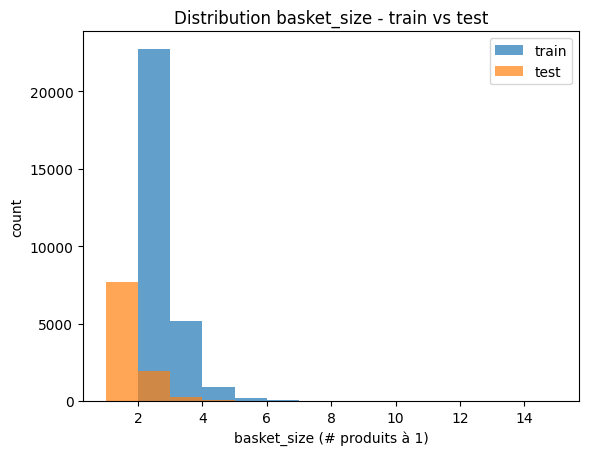

In [48]:
plt.figure()
plt.hist(train_basket, bins=range(int(train_basket.min()), int(train_basket.max()) + 2), alpha=0.7, label="train")
plt.hist(test_basket,  bins=range(int(test_basket.min()),  int(test_basket.max())  + 2), alpha=0.7, label="test")
plt.xlabel("basket_size (# produits à 1)")
plt.ylabel("count")
plt.title("Distribution basket_size - train vs test")
plt.legend()
plt.show()


La distribution de basket_size montre un décalage net entre Train (médiane=2, min=2) et Test (médiane=1, min=1). Ceci confirme la mécanique du jeu : le Test correspond à des paniers où un produit détenu a été masqué (1→0), ce qui réduit typiquement la taille du panier d’environ 1. Comme la majorité du Test a basket_size=1, le modèle devra souvent inférer le produit manquant à partir d’un seul produit observé, ce qui rend les co-occurrences produit-produit centrales. Pour la suite, nous analyserons les paires et associations fortes (lift/conditionnelles) et nous évaluerons les performances par basket_size (1 vs ≥2)

In [49]:
freq = pd.DataFrame({
    "train_count": train_basket.value_counts().sort_index(),
    "test_count":  test_basket.value_counts().sort_index()
}).fillna(0).astype(int)

freq["train_share"] = freq["train_count"] / len(train)
freq["test_share"]  = freq["test_count"]  / len(test)
freq["test_minus_train_share"] = freq["test_share"] - freq["train_share"]

freq.head(20)


,train_count,test_count,train_share,test_share,test_minus_train_share
1,0,7685,0.000000,0.7685,0.768500
2,22732,1921,0.780310,0.1921,-0.588210
3,5169,287,0.177434,0.0287,-0.148734
4,916,76,0.031443,0.0076,-0.023843
5,215,26,0.007380,0.0026,-0.004780
6,71,4,0.002437,0.0004,-0.002037
7,22,1,0.000755,0.0001,-0.000655
8,5,0,0.000172,0.0000,-0.000172
9,1,0,0.000034,0.0000,-0.000034
14,1,0,0.000034,0.0000,-0.000034


Le test est dominé par basket_size=1 (76.85% des lignes), alors que le train est dominé par basket_size=2 (78.03%), puis 3 (17.74%). Pour la suite, nous devrons suivre les performances par basket_size (au minimum : 1 vs ≥2), car la difficulté et la nature du signal changent fortement selon la taille du panier.

In [50]:
prev_train = train[PRODUCT_COLS].mean().sort_values(ascending=False)
prev_test  = test[PRODUCT_COLS].mean().sort_values(ascending=False)

prev = pd.DataFrame({"prev_train": prev_train, "prev_test": prev_test})
prev["gap_test_minus_train"] = prev["prev_test"] - prev["prev_train"]
prev


,prev_train,prev_test,gap_test_minus_train
66FJ,0.011637,0.0074,-0.004237
7POT,0.010847,0.0064,-0.004447
8NN1,0.005389,0.0036,-0.001789
AHXO,0.018502,0.0100,-0.008502
BSTQ,0.011122,0.0102,-0.000922
ECY3,0.037828,0.0233,-0.014528
FM3X,0.003776,0.0029,-0.000876
GHYX,0.030963,0.0186,-0.012363
GYSR,0.000137,0.0001,-0.000037
J9JW,0.048675,0.0323,-0.016375


Ici, nous trions les prévalences uniquement pour l’affichage. Attention : pour les calculs (lift, P(B|A)), nous utilisons toujours des prévalences alignées sur PRODUCT_COLS (non triées), sinon on désaligne les produits et on obtient des associations fausses.

Les produits ont une distribution très déséquilibrée (produits très fréquents vs rares), et les prévalences en test sont globalement plus faibles (effet du masquage). Pour la suite, cela implique (1) une baseline “popularité” forte mais trompeuse si on ne masque pas les produits déjà détenus, et (2) une attention aux produits rares (signal faible, métriques par produit utiles).

Le portefeuille est très déséquilibré : quelques produits fréquents et une longue traîne de produits rares. Pour la suite, cela impose (i) d’éviter une stratégie “popularité” naïve, (ii) de filtrer les associations par support, et (iii) de suivre des métriques par produit (rares vs fréquents).

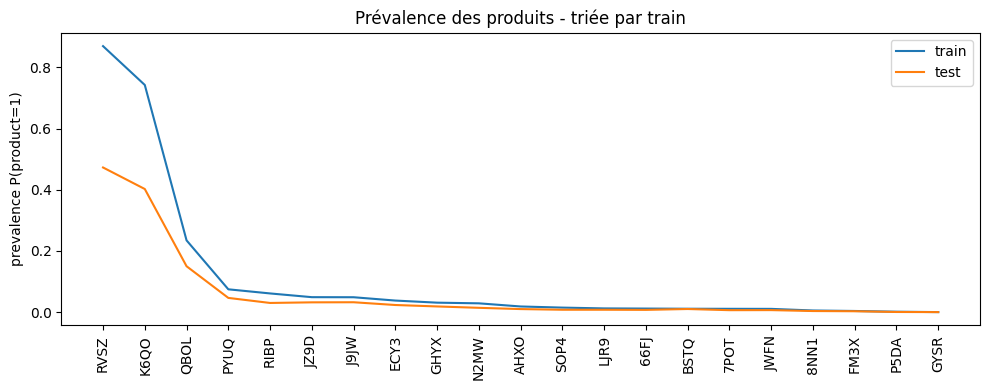

In [51]:
plt.figure(figsize=(10, 4))
plt.plot(prev_train.values, label="train")
plt.plot(prev_test.loc[prev_train.index].values, label="test")
plt.xticks(range(len(prev_train)), prev_train.index, rotation=90)
plt.ylabel("prevalence P(product=1)")
plt.title("Prévalence des produits - triée par train")
plt.legend()
plt.tight_layout()
plt.show()


Ce graphique sert à comprendre quels produits dominent le panier. Attention : un produit fréquent n’est pas forcément “le meilleur candidat” pour un client ; la recommandation doit exploiter la compatibilité panier (co-occurrence/conditionnelles), pas seulement la fréquence marginale.

Le profil de prévalence confirme un mix “produits piliers” très fréquents et une longue traîne de produits rares. Pour la recommandation Top-K, il faudra contrôler l’effet “dominance des populaires” (sinon le Top-K devient peu utile métier) et privilégier des scores basés sur compatibilité panier (co-occurrences/conditionnelles) plutôt que sur popularité brute.

In [52]:
X = train[PRODUCT_COLS].astype(int).values  # n x 21
n = X.shape[0]

co_counts = X.T @ X                          # 21x21, nb de clients avec A=1 et B=1
co_prob   = co_counts / n                    # P(A=1,B=1)

co_counts_df = pd.DataFrame(co_counts, index=PRODUCT_COLS, columns=PRODUCT_COLS)
co_prob_df   = pd.DataFrame(co_prob,   index=PRODUCT_COLS, columns=PRODUCT_COLS)



La matrice de co-occurrence mesure combien de clients possèdent simultanément deux produits (co_counts) et la probabilité correspondante P(A=1,B=1) (co_prob). Ces deux objets sont la base factuelle de toute baseline co-occurrence et des futures features dérivées “panier”.

co_counts(A,B) mesure combien de clients ont A et B ensemble ; co_prob(A,B)=P(A=1,B=1). Ces matrices sont la base factuelle de nos baselines panier (co-occurrence/conditionnelles) et de features dérivées

In [53]:
co_counts_df


,P5DA,RIBP,8NN1,7POT,66FJ,GYSR,SOP4,RVSZ,PYUQ,LJR9,...,AHXO,BSTQ,FM3X,K6QO,QBOL,JWFN,JZ9D,J9JW,GHYX,ECY3
P5DA,40,10,1,0,1,0,1,16,4,1,...,2,2,0,3,7,0,2,2,1,3
RIBP,10,1780,53,135,51,0,48,1041,200,150,...,9,21,5,398,482,6,20,20,15,92
8NN1,1,53,157,30,3,0,5,62,15,15,...,1,3,2,27,26,0,3,3,2,8
7POT,0,135,30,316,7,0,5,67,50,55,...,0,3,1,23,83,1,4,4,5,3
66FJ,1,51,3,7,339,1,9,214,30,14,...,2,2,0,81,75,1,2,2,4,18
GYSR,0,0,0,0,1,4,0,2,1,0,...,0,0,0,1,1,0,0,0,0,0
SOP4,1,48,5,5,9,0,431,280,41,29,...,0,1,1,88,88,1,6,6,2,25
RVSZ,16,1041,62,67,214,2,280,25328,1067,78,...,45,103,25,21629,5177,311,365,363,575,977
PYUQ,4,200,15,50,30,1,41,1067,2173,42,...,12,191,101,433,1010,11,197,196,58,34
LJR9,1,150,15,55,14,0,29,78,42,354,...,3,5,8,33,94,2,15,14,5,5


In [54]:
co_prob_df

,P5DA,RIBP,8NN1,7POT,66FJ,GYSR,SOP4,RVSZ,PYUQ,LJR9,...,AHXO,BSTQ,FM3X,K6QO,QBOL,JWFN,JZ9D,J9JW,GHYX,ECY3
P5DA,0.001373,0.000343,0.000034,0.000000,0.000034,0.000000,0.000034,0.000549,0.000137,0.000034,...,0.000069,0.000069,0.000000,0.000103,0.000240,0.000000,0.000069,0.000069,0.000034,0.000103
RIBP,0.000343,0.061101,0.001819,0.004634,0.001751,0.000000,0.001648,0.035734,0.006865,0.005149,...,0.000309,0.000721,0.000172,0.013662,0.016545,0.000206,0.000687,0.000687,0.000515,0.003158
8NN1,0.000034,0.001819,0.005389,0.001030,0.000103,0.000000,0.000172,0.002128,0.000515,0.000515,...,0.000034,0.000103,0.000069,0.000927,0.000892,0.000000,0.000103,0.000103,0.000069,0.000275
7POT,0.000000,0.004634,0.001030,0.010847,0.000240,0.000000,0.000172,0.002300,0.001716,0.001888,...,0.000000,0.000103,0.000034,0.000790,0.002849,0.000034,0.000137,0.000137,0.000172,0.000103
66FJ,0.000034,0.001751,0.000103,0.000240,0.011637,0.000034,0.000309,0.007346,0.001030,0.000481,...,0.000069,0.000069,0.000000,0.002780,0.002574,0.000034,0.000069,0.000069,0.000137,0.000618
GYSR,0.000000,0.000000,0.000000,0.000000,0.000034,0.000137,0.000000,0.000069,0.000034,0.000000,...,0.000000,0.000000,0.000000,0.000034,0.000034,0.000000,0.000000,0.000000,0.000000,0.000000
SOP4,0.000034,0.001648,0.000172,0.000172,0.000309,0.000000,0.014795,0.009611,0.001407,0.000995,...,0.000000,0.000034,0.000034,0.003021,0.003021,0.000034,0.000206,0.000206,0.000069,0.000858
RVSZ,0.000549,0.035734,0.002128,0.002300,0.007346,0.000069,0.009611,0.869422,0.036626,0.002677,...,0.001545,0.003536,0.000858,0.742448,0.177708,0.010676,0.012529,0.012461,0.019738,0.033537
PYUQ,0.000137,0.006865,0.000515,0.001716,0.001030,0.000034,0.001407,0.036626,0.074592,0.001442,...,0.000412,0.006556,0.003467,0.014863,0.034670,0.000378,0.006762,0.006728,0.001991,0.001167
LJR9,0.000034,0.005149,0.000515,0.001888,0.000481,0.000000,0.000995,0.002677,0.001442,0.012152,...,0.000103,0.000172,0.000275,0.001133,0.003227,0.000069,0.000515,0.000481,0.000172,0.000172


co_counts(A,B) mesure combien de clients ont les deux produits.


### Lift (force d’association)
lift(A,B) = P(A,B) / (P(A) P(B))

lift > 1 : A et B apparaissent ensemble plus que “par hasard”

lift ≈ 1 : indépendants

lift < 1 : s’excluent plutôt

Nous calculons le lift pour mesurer la force d’association entre deux produits au-delà de la simple popularité. 

In [55]:
# Prévalence dans le MÊME ordre que PRODUCT_COLS (surtout pas sort_values ici)
prev_train_aligned = train[PRODUCT_COLS].mean()  # index = PRODUCT_COLS, ordre intact
p = prev_train_aligned.values                   # numpy aligné

# Lift = P(A,B)/(P(A)P(B))
p_outer = np.outer(p, p)
lift = np.divide(co_prob, p_outer, out=np.zeros_like(co_prob), where=(p_outer > 0))

lift_df = pd.DataFrame(lift, index=PRODUCT_COLS, columns=PRODUCT_COLS)




Les valeurs élevées de lift indiquent des produits qui co-apparaissent beaucoup plus que prévu “par hasard”. Cependant, ces valeurs doivent toujours être lues avec leur support (nombre de clients ayant les deux produits) : un lift énorme sur un support faible peut être un artefact de rareté et ne pas être utile opérationnellement.

In [56]:
# (option) mettre la diagonale à 0 pour ne pas polluer
np.fill_diagonal(lift, 0.0)
lift_df = pd.DataFrame(lift, index=PRODUCT_COLS, columns=PRODUCT_COLS)

lift_df


,P5DA,RIBP,8NN1,7POT,66FJ,GYSR,SOP4,RVSZ,PYUQ,LJR9,...,AHXO,BSTQ,FM3X,K6QO,QBOL,JWFN,JZ9D,J9JW,GHYX,ECY3
P5DA,0.000000,4.091573,4.638854,0.000000,2.148378,0.000000,1.689791,0.460076,1.340635,2.057345,...,2.702412,4.495679,0.000000,0.101017,0.746100,0.000000,1.022175,1.027221,0.807428,1.982668
RIBP,4.091573,0.000000,5.524927,6.991929,2.462186,0.000000,1.822696,0.672667,1.506332,6.934870,...,0.273278,1.060778,0.743922,0.301160,1.154479,0.315748,0.229702,0.230836,0.272167,1.366333
8NN1,4.638854,5.524927,0.000000,17.615899,1.642072,0.000000,2.152600,0.454215,1.280862,7.862464,...,0.344256,1.718094,3.373712,0.231632,0.706045,0.000000,0.390640,0.392569,0.411428,1.347036
7POT,0.000000,6.991929,17.615899,0.000000,1.903626,0.000000,1.069488,0.243869,2.121258,14.323285,...,0.000000,0.853610,0.838090,0.098034,1.119824,0.296430,0.258779,0.260056,0.511030,0.250971
66FJ,2.148378,2.462186,1.642072,1.903626,0.000000,21.483776,1.794469,0.726078,1.186403,3.398563,...,0.318869,0.530464,0.000000,0.321825,0.943236,0.276319,0.120611,0.121206,0.381087,1.403659
GYSR,0.000000,0.000000,0.000000,0.000000,21.483776,0.000000,0.000000,0.575095,3.351588,0.000000,...,0.000000,0.000000,0.000000,0.336724,1.065857,0.000000,0.000000,0.000000,0.000000,0.000000
SOP4,1.689791,1.822696,2.152600,1.069488,1.794469,0.000000,0.000000,0.747223,1.275314,5.537169,...,0.000000,0.208616,0.614470,0.275004,0.870491,0.217336,0.284596,0.286001,0.149871,1.533386
RVSZ,0.460076,0.672667,0.454215,0.243869,0.726078,0.575095,0.747223,0.000000,0.564773,0.253432,...,0.096027,0.365647,0.261407,1.150190,0.871437,1.150190,0.294610,0.294442,0.733214,1.019723
PYUQ,1.340635,1.506332,1.280862,2.121258,1.186403,3.351588,1.275314,0.564773,0.000000,1.590584,...,0.298472,7.903126,12.309467,0.268387,1.981621,0.474180,1.853369,1.853064,0.862049,0.413626
LJR9,2.057345,6.934870,7.862464,14.323285,3.398563,0.000000,5.537169,0.253432,1.590584,0.000000,...,0.458036,1.269966,5.985003,0.125558,1.132097,0.529220,0.866250,0.812492,0.456174,0.373384


Le lift mesure la force d’association entre deux produits au-delà de la popularité : lift(A,B)=P(A,B)/(P(A)P(B)). Point critique : les prévalences doivent être alignées sur l’ordre des produits (PRODUCT_COLS), sinon on obtient des lifts faux. Ici, le calcul est aligné et interprétable.

In [57]:
MIN_SUPPORT = 50
pairs = []

for i, a in enumerate(PRODUCT_COLS):
    for j, b in enumerate(PRODUCT_COLS):
        if j <= i:
            continue
        support = co_counts_df.loc[a, b]
        if support >= MIN_SUPPORT:
            pairs.append((a, b, support, lift_df.loc[a, b], prev_train_aligned[a], prev_train_aligned[b]))

pairs_df = pd.DataFrame(pairs, columns=["A", "B", "support", "lift", "prevA", "prevB"])
pairs_df = pairs_df.sort_values(["lift", "support"], ascending=False)



In [58]:
pairs_df.head(20)





,A,B,support,lift,prevA,prevB
42,BSTQ,FM3X,85,69.478676,0.011122,0.003776
39,N2MW,AHXO,482,31.087411,0.028766,0.018502
58,JZ9D,J9JW,1418,20.443509,0.048915,0.048675
12,7POT,LJR9,55,14.323285,0.010847,0.012152
32,PYUQ,FM3X,101,12.309467,0.074592,0.003776
46,BSTQ,J9JW,168,10.652667,0.011122,0.048675
45,BSTQ,JZ9D,168,10.600338,0.011122,0.048915
31,PYUQ,BSTQ,191,7.903126,0.074592,0.011122
1,RIBP,7POT,135,6.991929,0.061101,0.010847
5,RIBP,LJR9,150,6.934870,0.061101,0.012152


Les lifts les plus élevés proviennent souvent de produits rares (faible prevA/prevB), ce qui peut produire des associations “spectaculaires” mais peu couvrantes. Pour la suite, nous priorisons les paires robustes via un double critère : support (co-occurrence suffisante) + lift > 1. Les paires à support élevé sont plus actionnables et généraliseront mieux.

Les premières paires sont dominées par des produits rares (prévalences très faibles), ce qui explique des lifts extrêmement élevés. Exemple : BSTQ–FM3X (lift ≈ 69) mais support = 85 et produits très rares. À l’inverse, des paires comme PYUQ–QBOL ont un support élevé (1010) et un lift > 1 (≈ 1.98) : ce sont des associations plus robustes et plus actionnables.

Les lifts les plus élevés proviennent souvent de produits rares (faible prevA/prevB), ce qui peut produire des associations “spectaculaires” mais peu couvrantes. Pour la suite, nous priorisons les paires robustes via un double critère : support (co-occurrence suffisante) + lift > 1. Les paires à support élevé sont plus actionnables et généraliseront mieux.


Pour construire une baseline et des features fiables, nous ne devons pas optimiser uniquement le lift : nous utiliserons une règle “double filtre” (support minimum + lift) et nous conserverons en priorité les associations à support élevé, car elles généralisent mieux et couvrent davantage de clients, ce qui est crucial sachant que la majorité du test a basket_size=1.

In [59]:
mask = (co_counts >= MIN_SUPPORT) & (lift > 1)
pivot_strength = np.where(mask, lift, 0.0).sum(axis=1)

pivot_df = pd.DataFrame({
    "product": PRODUCT_COLS,
    "pivot_strength": pivot_strength,
    "prevalence": prev_train_aligned.values
}).sort_values("pivot_strength", ascending=False)

pivot_df.head(10)


,product,pivot_strength,prevalence
12,BSTQ,100.003314,0.011122
13,FM3X,81.788143,0.003776
18,J9JW,35.200526,0.048675
17,JZ9D,35.152403,0.048915
11,AHXO,31.087411,0.018502
10,N2MW,31.087411,0.028766
8,PYUQ,29.528237,0.074592
1,RIBP,25.941053,0.061101
3,7POT,24.556296,0.010847
9,LJR9,22.390252,0.012152


Les lifts les plus élevés proviennent souvent de produits rares (faible prevA/prevB), ce qui peut produire des associations “spectaculaires” mais peu couvrantes. Pour la suite, nous priorisons les paires robustes via un double critère : support (co-occurrence suffisante) + lift > 1. Les paires à support élevé sont plus actionnables et généraliseront mieux.


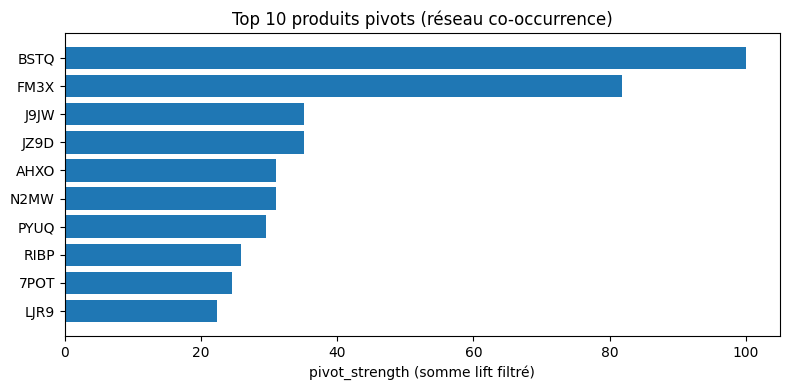

In [60]:
top = pivot_df.head(10).iloc[::-1]

plt.figure(figsize=(8, 4))
plt.barh(top["product"], top["pivot_strength"])
plt.xlabel("pivot_strength (somme lift filtré)")
plt.title("Top 10 produits pivots (réseau co-occurrence)")
plt.tight_layout()
plt.show()


Le score pivot_strength (somme des lifts vers d’autres produits, filtré par support) identifie les produits “très connectés”. Ici, BSTQ et FM3X ressortent comme pivots, mais ce sont aussi des produits très rares : leur pivot_strength est gonflé par quelques associations très fortes. À l’inverse, J9JW/JZ9D/PYUQ/RIBP ont des pivot_strength plus modérés mais avec des prévalences plus élevées, donc ils sont potentiellement plus utiles pour des recommandations qui couvrent une grande partie des clients.

Nous distinguons deux types de pivots : (1) pivots “rares” (fort lift, faible couverture) et (2) pivots “utiles” (bonne connectivité + couverture). Pour la suite, nous définirons un pivot score plus robuste en combinant connectivité et couverture (ex. somme des supports ou score pondéré support×log(lift)), afin d’éviter de survaloriser des produits rares.

In [61]:
# basket_size comme feature simple
train_features = pd.DataFrame({"ID": train["ID"], "basket_size": train_basket})
test_features  = pd.DataFrame({"ID": test["ID"],  "basket_size": test_basket})

train_features.head()


,ID,basket_size
0,4WKQSBB,2
1,CP5S02H,2
2,2YKDILJ,3
3,2S9E81J,2
4,BHDYVFT,2


basket_size est une feature dérivée simple mais structurante : elle mesure la quantité d’information produit-produit disponible. Pour la suite, nous l’utiliserons à la fois comme feature du modèle et comme axe d’analyse d’erreurs (performance et calibration selon basket_size, notamment basket_size=1 vs ≥2).

Comme le test est majoritairement à basket_size=1, une baseline mieux alignée est la recommandation via probabilités conditionnelles P(candidat=1 | produit_observé=1). En complément, nous proposons une variante robuste “log-lift borné” (clip + log1p) qui conserve la notion d’association tout en évitant les explosions.

In [63]:
# Co-occurrence déjà calculé: co_counts (21x21) et prev_train_aligned (P(A))
# co_prob = co_counts / n
# P(B|A) = P(A,B)/P(A) = co_prob / P(A)

pA = prev_train_aligned.values  
cond = np.divide(co_prob, pA.reshape(-1, 1), out=np.zeros_like(co_prob), where=(pA.reshape(-1,1) > 0))

cond_df = pd.DataFrame(cond, index=PRODUCT_COLS, columns=PRODUCT_COLS)
np.fill_diagonal(cond, 0.0)
cond_df = pd.DataFrame(cond, index=PRODUCT_COLS, columns=PRODUCT_COLS)




La baseline P(B|A) est directement adaptée à basket_size=1 : si un seul produit A est observé, recommander B revient à estimer P(B=1|A=1). Les scores étant bornés entre 0 et 1, ils sont comparables et constituent une référence saine pour la suite (le modèle ML devra faire mieux).

In [ ]:
cond_df


,P5DA,RIBP,8NN1,7POT,66FJ,GYSR,SOP4,RVSZ,PYUQ,LJR9,...,AHXO,BSTQ,FM3X,K6QO,QBOL,JWFN,JZ9D,J9JW,GHYX,ECY3
P5DA,0.000000,0.250000,0.025000,0.000000,0.025000,0.000000,0.025000,0.400000,0.100000,0.025000,...,0.050000,0.050000,0.000000,0.075000,0.175000,0.000000,0.050000,0.050000,0.025000,0.075000
RIBP,0.005618,0.000000,0.029775,0.075843,0.028652,0.000000,0.026966,0.584831,0.112360,0.084270,...,0.005056,0.011798,0.002809,0.223596,0.270787,0.003371,0.011236,0.011236,0.008427,0.051685
8NN1,0.006369,0.337580,0.000000,0.191083,0.019108,0.000000,0.031847,0.394904,0.095541,0.095541,...,0.006369,0.019108,0.012739,0.171975,0.165605,0.000000,0.019108,0.019108,0.012739,0.050955
7POT,0.000000,0.427215,0.094937,0.000000,0.022152,0.000000,0.015823,0.212025,0.158228,0.174051,...,0.000000,0.009494,0.003165,0.072785,0.262658,0.003165,0.012658,0.012658,0.015823,0.009494
66FJ,0.002950,0.150442,0.008850,0.020649,0.000000,0.002950,0.026549,0.631268,0.088496,0.041298,...,0.005900,0.005900,0.000000,0.238938,0.221239,0.002950,0.005900,0.005900,0.011799,0.053097
GYSR,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.500000,0.250000,0.000000,...,0.000000,0.000000,0.000000,0.250000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000
SOP4,0.002320,0.111369,0.011601,0.011601,0.020882,0.000000,0.000000,0.649652,0.095128,0.067285,...,0.000000,0.002320,0.002320,0.204176,0.204176,0.002320,0.013921,0.013921,0.004640,0.058005
RVSZ,0.000632,0.041101,0.002448,0.002645,0.008449,0.000079,0.011055,0.000000,0.042127,0.003080,...,0.001777,0.004067,0.000987,0.853956,0.204398,0.012279,0.014411,0.014332,0.022702,0.038574
PYUQ,0.001841,0.092039,0.006903,0.023010,0.013806,0.000460,0.018868,0.491026,0.000000,0.019328,...,0.005522,0.087897,0.046480,0.199264,0.464795,0.005062,0.090658,0.090198,0.026691,0.015647
LJR9,0.002825,0.423729,0.042373,0.155367,0.039548,0.000000,0.081921,0.220339,0.118644,0.000000,...,0.008475,0.014124,0.022599,0.093220,0.265537,0.005650,0.042373,0.039548,0.014124,0.014124


Si on lit la ligne RVSZ et la colonne K6QO : la valeur proche de 0.85 signifie “parmi les clients qui ont RVSZ, environ 85% ont aussi K6QO”.
C’est exactement le type de relation utile quand le test a basket_size=1 : on veut compléter le panier à partir d’un seul produit visible.

La baseline conditionnelle P(B|A) produit des scores bornés entre 0 et 1, directement interprétables, et particulièrement adaptés au cas dominant basket_size=1. La variante log-lift borné conserve une mesure d’association tout en stabilisant l’échelle (clip + log1p), ce qui évite les explosions observées avec la somme de lifts bruts. Pour la suite du projet, nous retenons la baseline conditionnelle comme référence principale, et le log-lift borné comme alternative “association-based” plus robuste.


In [ ]:
product_to_idx = {p: i for i, p in enumerate(PRODUCT_COLS)}

def score_conditional_for_client(row_products: pd.Series) -> pd.Series:
    owned_idx = [product_to_idx[p] for p in PRODUCT_COLS if row_products[p] == 1]
    if not owned_idx:
        scores = np.zeros(len(PRODUCT_COLS))
    else:
        # moyenne des P(B|A) pour les produits observés
        scores = cond[:, owned_idx].mean(axis=1)

    # Masque: ne pas recommander les produits déjà détenus
    for p in PRODUCT_COLS:
        if row_products[p] == 1:
            scores[product_to_idx[p]] = -np.inf

    return pd.Series(scores, index=PRODUCT_COLS)

example_scores = score_conditional_for_client(train.loc[0, PRODUCT_COLS])
example_scores.sort_values(ascending=False).head(5)


JWFN    0.985531
ECY3    0.714156
QBOL    0.628348
GHYX    0.547672
66FJ    0.435103
dtype: float64

Le Top-5 affiché signifie : “pour ce client précis, étant donné les produits déjà visibles dans son panier, les produits les plus compatibles (au sens co-occurrence) sont JWFN, ECY3, QBOL, GHYX, 66FJ.”

Les valeurs sont des probabilités conditionnelles moyennées, donc elles sont interprétables :

JWFN = 0.985 est extrêmement haut : cela veut dire que, compte tenu des produits observés chez ce client, JWFN est presque toujours présent chez des clients similaires (selon la statistique du train).
C’est un signal très fort, mais à ce stade ce n’est pas encore “une probabilité d’achat” : c’est une probabilité de co-possession dans le dataset

Une probabilité conditionnelle élevée n’est fiable que si elle est estimée sur un volume suffisant. Nous analysons donc le support : combien de clients possèdent le produit A (taille de l’échantillon utilisé pour estimer P(B|A)). Nous analysons aussi le support des paires (A,B) pour distinguer une relation robuste d’un artefact dû à un produit rare.

In [66]:
# Support de A : nb de clients avec A=1 (dénominateur de P(B|A))
support_A = train[PRODUCT_COLS].sum(axis=0).astype(int)  # Series index=PRODUCT_COLS
support_A_df = support_A.to_frame("support_A").sort_values("support_A", ascending=False)

support_A_df.head(10)


,support_A
RVSZ,25328
K6QO,21629
QBOL,6833
PYUQ,2173
RIBP,1780
JZ9D,1425
J9JW,1418
ECY3,1102
GHYX,902
N2MW,838


In [67]:
MIN_SUPPORT_A = 200     # A doit être suffisamment fréquent
MIN_SUPPORT_AB = 50     # la paire A&B doit apparaître suffisamment

rules = []
for i, A in enumerate(PRODUCT_COLS):
    supA = int(support_A[A])
    if supA < MIN_SUPPORT_A:
        continue

    for j, B in enumerate(PRODUCT_COLS):
        if B == A:
            continue
        supAB = int(co_counts_df.loc[A, B])
        if supAB < MIN_SUPPORT_AB:
            continue

        rules.append((A, B, supA, supAB, cond_df.loc[A, B], prev_train_aligned[B]))

rules_df = pd.DataFrame(rules, columns=["A", "B", "support_A", "support_AB", "P(B|A)", "prev_B"])
rules_df = rules_df.sort_values(["P(B|A)", "support_AB"], ascending=False)

rules_df.head(20)


,A,B,support_A,support_AB,P(B|A),prev_B
66,K6QO,RVSZ,21629,21629,1.000000,0.869422
106,J9JW,JZ9D,1418,1418,1.000000,0.048915
91,JWFN,RVSZ,311,311,1.000000,0.869422
99,JZ9D,J9JW,1425,1418,0.995088,0.048675
92,JWFN,K6QO,311,302,0.971061,0.742448
55,AHXO,N2MW,539,482,0.894249,0.028766
115,ECY3,RVSZ,1102,977,0.886570,0.869422
30,RVSZ,K6QO,25328,21629,0.853956,0.742448
80,QBOL,RVSZ,6833,5177,0.757647,0.869422
18,SOP4,RVSZ,431,280,0.649652,0.869422


Les plus grandes valeurs de P(B|A) peuvent venir de deux situations : (1) une vraie relation “bundle” robuste (support_A et support_AB élevés), ou (2) une relation artificiellement élevée parce que A est rare (petit support_A). Nous gardons donc comme “associations exploitables” celles qui ont à la fois une probabilité conditionnelle élevée et un support suffisant.

Nous rendons la baseline conditionnelle plus robuste en pondérant l’information apportée par chaque produit observé. Intuition : si un produit observé est très rare, les probabilités P(B|A) associées sont estimées sur peu d’exemples et sont donc moins fiables ; on lui donne donc un poids plus faible. À l’inverse, un produit fréquent apporte une estimation plus stable et pèse davantage dans le score final.

In [69]:
support_A = train[PRODUCT_COLS].sum(axis=0).astype(float)  # float pour les poids
support_A = support_A.reindex(PRODUCT_COLS)                # sécurité alignement

product_to_idx = {p: i for i, p in enumerate(PRODUCT_COLS)}

def score_conditional_weighted_for_client(row_products: pd.Series) -> pd.Series:
    # Produits observés (A)
    owned = [p for p in PRODUCT_COLS if row_products[p] == 1]
    owned_idx = [product_to_idx[p] for p in owned]

    if not owned_idx:
        scores = np.zeros(len(PRODUCT_COLS))
    else:
        # Poids = fonction croissante du support (plus A est fréquent, plus il pèse)
        # Choix robuste: sqrt(support) évite qu’un produit ultra fréquent domine trop
        w = np.sqrt(support_A.loc[owned].values)  # shape (m,)
        w_sum = w.sum()

        if w_sum <= 0:
            scores = cond[:, owned_idx].mean(axis=1)
        else:
            # Moyenne pondérée: sum_j w_j * P(B|A_j) / sum_j w_j
            scores = (cond[:, owned_idx] * w.reshape(1, -1)).sum(axis=1) / w_sum

    # Masque métier: ne pas recommander les produits déjà détenus
    for p in owned:
        scores[product_to_idx[p]] = -np.inf

    return pd.Series(scores, index=PRODUCT_COLS)



Cette version pondérée réduit l’influence des produits rares (estimations instables) et privilégie les signaux issus de produits fréquents (estimations plus fiables). Elle reste adaptée au cas dominant basket_size=1 (où elle se réduit à P(B|A)), et devient plus robuste lorsque plusieurs produits sont observés.

In [71]:
example_scores_w = score_conditional_weighted_for_client(train.loc[0, PRODUCT_COLS])
example_scores_w.sort_values(ascending=False).head(5)


JWFN    0.986101
ECY3    0.720958
QBOL    0.633448
GHYX    0.551214
66FJ    0.442842
dtype: float64

In [72]:
example_scores = score_conditional_for_client(train.loc[0, PRODUCT_COLS])
comp = pd.DataFrame({
    "unweighted": example_scores,
    "weighted": example_scores_w
}).replace(-np.inf, np.nan)

comp.sort_values("weighted", ascending=False).head(10)


,unweighted,weighted
JWFN,0.985531,0.986101
ECY3,0.714156,0.720958
QBOL,0.628348,0.633448
GHYX,0.547672,0.551214
66FJ,0.435103,0.442842
SOP4,0.426914,0.435701
RIBP,0.404213,0.411339
GYSR,0.375000,0.379931
PYUQ,0.345145,0.350900
8NN1,0.283439,0.287837
